In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class VGG(nn.Module):
    def __init__(self, arch, lr = 0.01, num_classes = 10):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        conv_blocks = []
        for (num_convs, out_channels) in arch:
            conv_blocks.append(self.vgg_block(num_convs,out_channels))
        self.net = nn.Sequential(*conv_blocks, nn.Flatten(),
                                nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
                                nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
                                nn.LazyLinear(num_classes)
                                )
        self.net.apply(self.init_cnn)
    
    @staticmethod
    def vgg_block(num_convs, out_channels):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
            layers.append(nn.LazyBatchNorm2d())
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
        return nn.Sequential(*layers)
    

        
    def init_cnn(self, layer):
        if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
            nn.init.xavier_normal_(layer.weight)
            
    def forward(self,x):
        return self.net(x)
    
    def apply_init(self,inputs, init= None):
        for inp in inputs:
            inp.to(device)
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

In [18]:
# Load CIFAR-10 dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

In [19]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [20]:
# Train the network
valid_losses = []
train_losses = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            train_losses.append(running_loss / 1000)
            running_loss = 0.0
        
    model.eval()

    total_valid_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()
        average_valid_loss = total_valid_loss / len(testloader)
        valid_losses.append(average_valid_loss)
    model.train()
        
    print('[%d] validation loss: %.3f' % (epoch + 1, average_valid_loss))
    total_valid_loss = 0.0
            
print('Finished Training')

[1,  1000] training loss: 1.882
[1,  2000] training loss: 1.540
[1,  3000] training loss: 1.318
[1] validation loss: 1.132
[2,  1000] training loss: 1.101
[2,  2000] training loss: 0.974
[2,  3000] training loss: 0.883
[2] validation loss: 0.829
[3,  1000] training loss: 0.773
[3,  2000] training loss: 0.725
[3,  3000] training loss: 0.717
[3] validation loss: 0.679
[4,  1000] training loss: 0.605
[4,  2000] training loss: 0.593
[4,  3000] training loss: 0.605
[4] validation loss: 0.583
[5,  1000] training loss: 0.476
[5,  2000] training loss: 0.505
[5,  3000] training loss: 0.499
[5] validation loss: 0.550
[6,  1000] training loss: 0.402
[6,  2000] training loss: 0.412
[6,  3000] training loss: 0.429
[6] validation loss: 0.517
[7,  1000] training loss: 0.323
[7,  2000] training loss: 0.340
[7,  3000] training loss: 0.356
[7] validation loss: 0.538
[8,  1000] training loss: 0.261
[8,  2000] training loss: 0.305
[8,  3000] training loss: 0.311
[8] validation loss: 0.542
[9,  1000] train

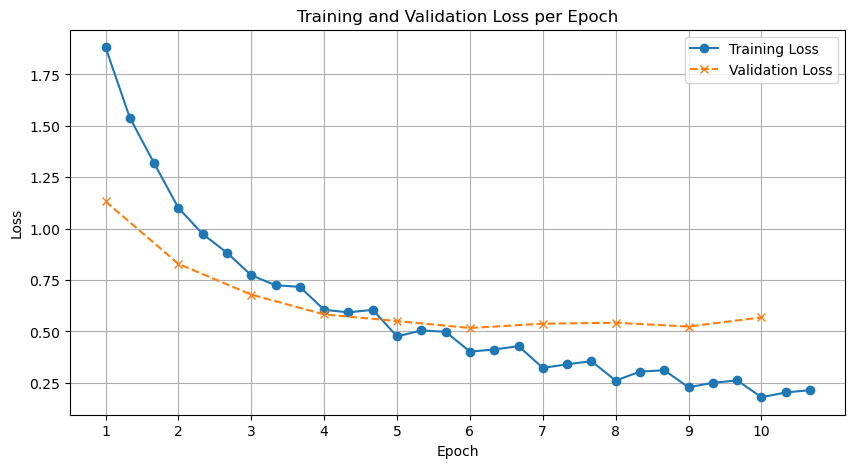

In [21]:
epochs = range(1, 11)  # 10 epochs
training_epochs = [x / 3 + 1 for x in range(len(train_losses))]  # 30 points, scaled to 10 epochs

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(training_epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, valid_losses, label='Validation Loss', marker='x', linestyle='--')

# Adding titles and labels
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)  # Ensure only epoch numbers are marked

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
